<h1 align="center"> Image Captioning </h1>

![img](https://i.imgur.com/obITaMl.png)

## План

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/1z9VnhbJhDyk1Q)

План:

1. Скачаем датасет (векторы картинок и соответствующие описания).
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса. 
3. Напишем вторую RNN сеть, которая будет брать векторы из Inception-v3 и генерировать описания.
4. Обучим вторую сеть на MSCOCO
5. Напишем telegram бота.

# Подготовка

## Загрузка датасета

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!tar -xvf /content/gdrive/My\ Drive/Colab\ Notebooks/DLS_2/DLS2_project_Image_Captioning/handout.tar.gz

data/
data/captions_tokenized.json
data/image_codes.npy


In [ ]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [ ]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


## Предобработка текстов из датасета

Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения. 
2. Посчитать частоту встречания каждого слова из словаря и оставить только те, которые встречаются больше Х раз (например, Х=5).
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа.
4. Написать функцию, которая будет возвращать батч из описаний. Батч должен выглядеть примерно так:

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

In [ ]:
all_captions = []
for one_pic_captions in captions: # итерация по картинкам
  for pic_caption in one_pic_captions: # по описаниям к 1 картинке
    all_captions.append(pic_caption.split())

print(all_captions[:6])

[['people', 'shopping', 'in', 'an', 'open', 'market', 'for', 'vegetables', '.'], ['an', 'open', 'market', 'full', 'of', 'people', 'and', 'piles', 'of', 'vegetables', '.'], ['people', 'are', 'shopping', 'at', 'an', 'open', 'air', 'produce', 'market', '.'], ['large', 'piles', 'of', 'carrots', 'and', 'potatoes', 'at', 'a', 'crowded', 'outdoor', 'market', '.'], ['people', 'shop', 'for', 'vegetables', 'like', 'carrots', 'and', 'potatoes', 'at', 'an', 'open', 'air', 'market', '.'], ['a', 'person', 'skiing', 'down', 'a', 'steep', 'hill']]


In [ ]:
caption_lens = np.array([len(all_captions[i]) for i in range(len(all_captions))])
print('Средняя длина предложения = ', caption_lens.mean() )
print('Максимальная длина предложения = ', caption_lens.max() )
print('Доля предложений в котором <= 16 слов = ', len(caption_lens[caption_lens<=16])/len(caption_lens) )

Средняя длина предложения =  11.292223152163805
Максимальная длина предложения =  57
Доля предложений в котором <= 16 слов =  0.9633535384277224


Создаем словарь:

In [ ]:
from torchtext.data import Field

max_len = 18

TRG = Field(init_token = '<sos>', 
            eos_token = '<eos>',
            batch_first=True, 
            lower = True,
            fix_length = max_len)

TRG.build_vocab(all_captions, min_freq = 5)
print('Количество слов в словаре:', len(TRG.vocab))

PAD_IDX = TRG.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

Количество слов в словаре: 10403


Сохраним словарь:

In [ ]:
# import dill

# # сохраним словарь
# TRG_SAVE_PATH = "gdrive/My Drive/Colab Notebooks/DLS_2/DLS2_project_Image_Captioning/TRG.Field"
# with open(TRG_SAVE_PATH,"wb")as f:
#      dill.dump(TRG,f)

Посмотрим на словарь:

In [ ]:
for i in range(16):
  print(i, TRG.vocab.itos[i], end=' | ')

0 <unk> | 1 <pad> | 2 <sos> | 3 <eos> | 4 a | 5 . | 6 on | 7 of | 8 the | 9 in | 10 with | 11 and | 12 is | 13 man | 14 to | 15 sitting | 

Перевод слов в индексы:

In [ ]:
# перевод слов в индексы
def process_batch_captions(batch_captions):
  return TRG.process([one_caption.split() for one_caption in batch_captions])

Перевод индексов в слова:

In [ ]:
# перевод индексов в слова (без <sos> и <eos>)
def idx_to_sent(outputs):
    all_captions = []
    for i, output in enumerate(outputs): # цикл по батчу
        one_caption = []
        for word_idx in output: # цикл по словам
            word_idx = int(word_idx.item())
            if word_idx == EOS_IDX:
              break
            elif word_idx == SOS_IDX:
              pass
            else:
              one_caption.append(TRG.vocab.itos[word_idx])
        all_captions.append(' '.join(one_caption))
    return all_captions

## Формирование датасета и батчевалка

Поделим выборку на train/test:

In [ ]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions, #12800
                                                                                test_size=0.1,
                                                                                random_state=42)
len(train_img_codes), len(val_img_codes)

(106458, 11829)

Batch генератор:

In [ ]:
from random import choice
import torch

def generate_batch(img_codes, captions, batch_size, return_all = False):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images)) # random caption
    # batch_captions = captions_for_batch_images[:, 0] # only first caption
    # batch_captions = [min(captions_for_batch_images[i], key = len) for i in range(len(captions_for_batch_images))] # the shortest
    
    #convert to matrix
    batch_captions_ix = process_batch_captions(batch_captions)

    if return_all == False:
      return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    else:
      return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64), captions_for_batch_images

# RNN сеть для вывода описаний картинок


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Построение RNN модели

Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens, max_len, emb_dim=256, cnn_feature_size=2048, hid_dim=512, n_layers=2, dropout=0.1):
        super(self.__class__, self).__init__()
        
        self.max_len = max_len
        self.n_tokens = n_tokens
        self.n_layers = n_layers
        self.hid_dim = hid_dim

        self.cnn_to_h0 = nn.Linear(cnn_feature_size, hid_dim)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, hid_dim)

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.embedding = nn.Embedding(n_tokens, emb_dim)
            
        # lstm: настакайте LSTM-ок (1 или более, но не надо сразу пихать больше двух, замучаетесь ждать).
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
            
        # ну и линейный слой для получения логитов
        self.out1 = nn.Linear(hid_dim, hid_dim*2)
        self.out2 = nn.Linear(hid_dim*2, n_tokens)
        
    def forward(self, image_vectors, captions_ix, teacher_forcing_ratio=0.5, top_k=1):

        batch_size = image_vectors.shape[0]

        #get initial_cell and initial_hid for LSTM
        hidden = self.cnn_to_h0(image_vectors).unsqueeze(0).repeat(self.n_layers,1,1) # -> [n_layers, batch_size, hid_dim]
        cell = self.cnn_to_c0(image_vectors).unsqueeze(0).repeat(self.n_layers,1,1) # -> [n_layers, batch_size, hid_dim]
        
        #tensor to store logits, shape: [max_len-1, batch_size, n_tokens]
        logits = torch.zeros(self.max_len-1, batch_size, self.n_tokens).to(device)
 
        #first input is the <sos> tokens
        input = torch.ones((batch_size,), dtype=torch.int64).to(device) * SOS_IDX # [batch_size]
   
        for t in range(0, self.max_len-1):
            embedded = self.embedding(input.unsqueeze(0)) # -> [1, batch_size, emb_dim], 1 serves as sent len
            output, (hidden, cell) = self.rnn(embedded, (hidden, cell)) # -> [1, batch_size, hid_dim], [n_layers, batch_size, hid_dim]x2
            logit = self.out2(F.relu(self.out1(output.squeeze(0)))) # -> [batch_size, n_tokens]
            logits[t] = logit # -> [max_len, batch_size, n_tokens]
            
            if top_k == 1:
                top1 = logit.max(1)[1] # -> [batch_size] (indices of max logits in batch)
            else:
                # рандомный выбор из top_k
                topk_idx = torch.topk(logit, k=3, dim=1)[1] # -> [batch_size, k] 
                top1 = topk_idx[:,torch.randint(0, top_k, (1,))].squeeze(1) # -> [batch_size]

            teacher_force = random.random() < teacher_forcing_ratio    
            input = (captions_ix[:, t] if teacher_force else top1)
        
        return logits.permute(1,0,2) # -> [batch_size, max_len-1, n_tokens]
#-----------------------------------------------------------------------------
    def fast_forward(self, image_vectors, captions_ix):
        hidden = self.cnn_to_h0(image_vectors).unsqueeze(0).repeat(self.n_layers,1,1) # -> [n_layers, batch_size, hid_dim]
        cell = self.cnn_to_c0(image_vectors).unsqueeze(0).repeat(self.n_layers,1,1) # -> [n_layers, batch_size, hid_dim]
        embedded = self.embedding(captions_ix.permute(1,0)) # -> [max_len, batch_size, emb_dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell)) # -> [max_len, batch_size, hid_dim], [n_layers, batch_size, hid_dim]x2
        logits = self.out2(F.relu(self.out1(output.squeeze(0)))) # -> [batch_size, n_tokens]
        return logits.permute(1,0,2) # -> [batch_size, max_len, n_tokens]    
#-----------------------------------------------------------------------------
    def generate_caption(self, image_vectors, top_k=1):
        with torch.no_grad():

            batch_size = image_vectors.shape[0]
            hidden = self.cnn_to_h0(image_vectors).unsqueeze(0).repeat(self.n_layers,1,1) # -> [n_layers, batch_size, hid_dim]
            cell = self.cnn_to_c0(image_vectors).unsqueeze(0).repeat(self.n_layers,1,1) # -> [n_layers, batch_size, hid_dim]
            
            #tensor to store outputs, shape: [batch_size, max_len-1]
            outputs = torch.zeros((batch_size, self.max_len-1), dtype=torch.int64).to(device)
            
            # array to store probabilities for confidence calculation
            probs = np.zeros((batch_size, self.max_len-1))
      
            #first input is the <sos> tokens
            input = torch.ones((batch_size,), dtype=torch.int64).to(device) * SOS_IDX # [batch_size]

            for t in range(0, self.max_len-1):
              embedded = self.embedding(input.unsqueeze(0)) # -> [1, batch_size, emb_dim], 1 serves as sent len
              output, (hidden, cell) = self.rnn(embedded, (hidden, cell)) # -> [1, batch_size, hid_dim], [n_layers, batch_size, hid_dim]x2
              logit = self.out2(F.relu(self.out1(output.squeeze(0)))) # -> [batch_size, n_tokens]
              
              if top_k == 1:
                  top1 = logit.max(1)[1] # -> [batch_size] (indices of max logits in batch)
              else:
                 
                  # взвешенный выбор из top_k
                  topk_logit, topk_idx = torch.topk(logit, k=top_k, dim=1) # top_k логитов и их индексы
                  topk_probs = F.softmax(topk_logit, dim=1).cpu().numpy() # вероятности top_k логитов
                  topk_logit = topk_logit.cpu().numpy()
                  topk_idx = topk_idx.cpu().numpy()

                  # returning confidence
                  choosed1 = np.array([np.random.choice(top_k, 1, p=topk_probs[i]) \
                                        for i in range(batch_size)]).squeeze(1)  # -> [batch_size]
                  top1 = topk_idx[np.arange(len(topk_idx)), choosed1] # -> [batch_size]
                  top1 = torch.tensor(top1, dtype=torch.int64).to(device) # -> [batch_size]
                  prob1 = topk_probs[np.arange(len(topk_probs)), choosed1]
                  probs[:, t] = prob1
      
              input = top1
              outputs[:, t] = top1 # -> [batch_size, max_len-1]

        outputs = outputs.detach().cpu().numpy() # -> [batch_size, max_len-1]
        confidence = np.prod(probs, axis=1)**(1/max_len)      # -> [batch_size]
        return outputs, confidence # -> [batch_size, max_len-1], [batch_size]

## Вычисление Loss

In [ ]:
def compute_loss(model, image_vectors, captions_ix, criterion, teacher_forcing_ratio=1.0, top_k=1):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_next = captions_ix[:, 1:].contiguous()
    captions_ix_inp = captions_ix[:, :-1].contiguous()

    # apply the network, get predictions for captions_ix_next
    if teacher_forcing_ratio == 1.0:
        logits_for_next = model.fast_forward(image_vectors, captions_ix_inp)
    else:
        logits_for_next = model.forward(image_vectors, captions_ix, teacher_forcing_ratio, top_k)
    
    # flattening  
    logits_for_next = logits_for_next.reshape(-1, logits_for_next.shape[-1]) # -> [batch_size*(max_len), n_tokens]
    captions_ix_next = captions_ix_next.view(-1)  # -> [batch_size*(max_len)]

    # compute the loss function between logits_for_next and captions_ix_next
    loss = criterion(logits_for_next, captions_ix_next)

    return loss


## Обучение модели

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [ ]:
def train(model, optimizer, criterion, clip, batch_size, teacher_forcing_ratio=1.0, top_k=1):
    
    model.train()

    epoch_losses = []
    n_batches = len(train_img_codes) // batch_size

    for i in tqdm(range(n_batches)):
        
        (batch_images, batch_captions_ix) = generate_batch(train_img_codes, train_captions, batch_size)
        
        optimizer.zero_grad()
        loss = compute_loss(model, batch_images.to(device), batch_captions_ix.to(device),
                            criterion, teacher_forcing_ratio, top_k) # teacher forcing
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_losses += [loss.item()]
        
    return epoch_losses

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def calc_bleu(references, predictions):
  predictions = [p.split() for p in predictions]
  references = list(references)
  for i in range(len(references)):
      references[i] = [r.split() for r in references[i]]
  return corpus_bleu(references, predictions)

In [ ]:
def evaluate(model, criterion, batch_size):
    
    model.eval()

    epoch_bleus = 0
    n_batches = len(val_img_codes) // batch_size
    
    with torch.no_grad():
        for i in tqdm(range(n_batches)):
            (batch_images, batch_captions_ix, refs) = generate_batch(train_img_codes, train_captions, batch_size, True)

            # BLEU
            outputs, _ = model.generate_caption(batch_images.to(device), top_k=1) # top_k=1!
            epoch_bleus += calc_bleu(refs, idx_to_sent(outputs))
        
    return epoch_bleus/n_batches

Инициализация:

In [ ]:
model = CaptionNet( n_tokens=len(TRG.vocab) , max_len=max_len ).to(device) 

In [ ]:
best_val_bleu = -1
batch_size = 64
clip = 1

all_train_losses, all_val_bleus = [], []

Обучение:




In [ ]:
MODEL_SAVE_PATH = 'gdrive/My Drive/Colab Notebooks/DLS_2/DLS2_project_Image_Captioning/rnn_model_temp.pt'

n_epochs = 20
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)


for epoch in tqdm(range(n_epochs)):
    
    train_losses = train(model, optimizer, criterion, clip, batch_size,
                         teacher_forcing_ratio=1.0, top_k=1)
    train_loss = sum(train_losses) / len(train_losses)
    val_bleu = evaluate(model, criterion, batch_size)

    all_train_losses += train_losses
    all_val_bleus += [val_bleu,]

    if val_bleu > best_val_bleu:
        best_val_bleu = val_bleu
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print('Epoch: {} | Train Loss {:.3f} |  Val Bleu {:.3f}'.format(epoch+1, train_loss, val_bleu))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch: 1 | Train Loss 3.33 |  Val Bleu 0.179



Epoch: 2 | Train Loss 2.67 |  Val Bleu 0.194



Epoch: 3 | Train Loss 2.51 |  Val Bleu 0.204



Epoch: 4 | Train Loss 2.43 |  Val Bleu 0.215



Epoch: 5 | Train Loss 2.37 |  Val Bleu 0.214



Epoch: 6 | Train Loss 2.32 |  Val Bleu 0.224



Epoch: 7 | Train Loss 2.28 |  Val Bleu 0.218



Epoch: 8 | Train Loss 2.26 |  Val Bleu 0.225



Epoch: 9 | Train Loss 2.22 |  Val Bleu 0.218



Epoch: 10 | Train Loss 2.21 |  Val Bleu 0.222



Epoch: 11 | Train Loss 2.19 |  Val Bleu 0.229



Epoch: 12 | Train Loss 2.17 |  Val Bleu 0.226



Epoch: 13 | Train Loss 2.16 |  Val Bleu 0.225



Epoch: 14 | Train Loss 2.15 |  Val Bleu 0.23



Epoch: 15 | Train Loss 2.13 |  Val Bleu 0.23



Epoch: 16 | Train Loss 2.12 |  Val Bleu 0.232



Epoch: 17 | Train Loss 2.12 |  Val Bleu 0.235



Epoch: 18 | Train Loss 2.11 |  Val Bleu 0.232



Epoch: 19 | Train Loss 2.1 |  Val Bleu 0.231



Epoch: 20 | Train Loss 2.09 |  Val Bleu 0.23



min train_loss = 1.996, max val_bleu = 0.235


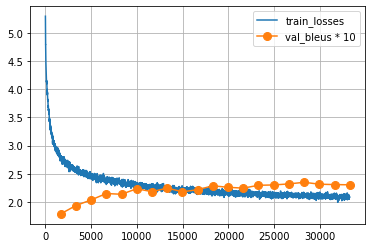

In [ ]:
from matplotlib import pyplot as plt

all_train_losses_c = np.convolve(np.array(all_train_losses[10:]), np.ones(20)/20, mode='valid')

print('min train_loss = {:.3f}, max val_bleu = {:.3f}'.format(min(all_train_losses_c),
                                                    max(all_val_bleus)))

plt.plot(all_train_losses_c, label='train_losses')
n_epochs = len(all_val_bleus)
plt.plot([i*len(all_train_losses)/n_epochs for i in range(1, n_epochs+1)], np.array(all_val_bleus)*10,
         label='val_bleus * 10', marker='o', markersize=8)
plt.legend()
plt.grid()
plt.show();

In [ ]:
# проверим описания картинок из датасета
model.eval()
with torch.no_grad():
    batch_images, batch_5captions_ix = img_codes[1000:1010], captions[1000:1010]
    outputs, _ = model.generate_caption(torch.Tensor(batch_images).to(device), top_k=3)
    print('\n'.join(idx_to_sent(outputs)))

a man in a suit holding a cell phone .
a dog is laying down on a field with a frisbee .
two giraffes standing in a zoo enclosure
the snow board is attached to the side of a wall .
a couple of zebras that are standing in a pin
a group of people are on the shore of a beach .
a man is walking down the road with a bike .
a swiss army knife with a pair of scissors on top .
a giraffe is standing in a field of tall grass
a woman riding a wave on top of a surfboard in the ocean .


# Генерация описаний


## Загрузка моделей

RNN model:

In [ ]:
# Загрузка ранее сохраненной модели
MODEL_SAVE_PATH = 'gdrive/My Drive/Colab Notebooks/DLS_2/DLS2_project_Image_Captioning/rnn_model_best.pt'
model = CaptionNet( n_tokens=len(TRG.vocab) , max_len=max_len ).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

Inception:

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DLS_2/DLS2_project_Image_Captioning')

# загружаем inception
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

## Скачаем пару картинок и сгенерируем описание

In [ ]:
def generate_from_images(images, top_k=1):
    for image in images:
      assert isinstance(image, np.ndarray) and np.max(image) <= 1\
            and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        images = torch.tensor(images.transpose([0, 3, 1, 2]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(images) # [1, 2048, 8, 8] | [1, 2048] | [1, 1000]

        outputs, confidence = model.generate_caption(vectors_neck.to(device), top_k)
        return idx_to_sent(outputs), confidence

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline

2020-07-06 15:41:17 URL:https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [54731/54731] -> "img.jpg" [1]


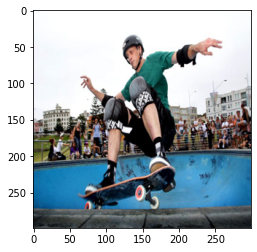

topk=1: A man riding a skateboard down the side of a ramp .
0.731 : A man riding a skateboard up the side of a ramp .
0.678 : A man riding a skateboard on top of a ramp .
0.636 : A man riding a skateboard down the middle of a ramp .
0.614 : A man riding a skateboard down the top of a ramp .
0.613 : A man flying through the air on top of a skateboard .
0.591 : A skateboarder performing a trick at a skateboard park .
0.553 : A man is doing a trick on a skateboard .
0.525 : A man is doing skateboard tricks on a ramp
0.503 : A young man riding a skateboard on a ramp .
0.494 : A skateboarder in the middle of a trick .


In [ ]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg --no-verbose
img = Image.open('img.jpg')
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

caps, _ = generate_from_images(img[None], top_k=1)
print('topk=1: {}'.format(caps[0].capitalize() ))

batch_img = np.repeat(img[None], repeats=20, axis=0) # 20 копий
caps, confs = generate_from_images(batch_img, top_k=5)
confs, caps = zip( *sorted(zip(confs, caps))[::-1] )
for i in range(len(caps[:10])): # вывод 10 лучших описаний
    print('{:.3f} : {}'.format(confs[i], caps[i].capitalize() ))

2020-07-06 15:41:06 URL:https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [106870/106870] -> "img.jpg" [1]


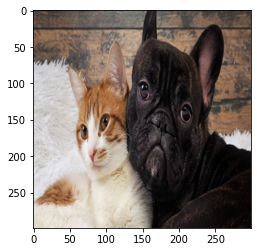

topk=1: A cat is sitting on a couch with a remote .
0.547 : A cat that is laying in the grass .
0.500 : A black cat is sitting in the grass next to a pair of shoes .
0.457 : A cat that is looking at something in a glass .
0.431 : A cat that is sitting on a couch .
0.429 : A cat with a collar and tag eyes on its head .
0.420 : A cat is sitting on the ground with a toy banana .
0.419 : The cat is looking at the camera while in his hat .
0.416 : A cat with a collar sits on its back .
0.415 : The cat is lying down in the corner of a chair .
0.404 : A close up of the back of a black cat


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg --no-verbose
img = Image.open('img.jpg')
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

caps, _ = generate_from_images(img[None], top_k=1)
print('topk=1: {}'.format(caps[0].capitalize() ))

batch_img = np.repeat(img[None], repeats=20, axis=0) # 20 копий
caps, confs = generate_from_images(batch_img, top_k=5)
confs, caps = zip( *sorted(zip(confs, caps))[::-1] )
for i in range(len(caps[:10])): # вывод 10 лучших описаний
    print('{:.3f} : {}'.format(confs[i], caps[i].capitalize() ))

# TelegramBot

## Подготовим все необходимое

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


RNN model:

In [ ]:
# НУЖНО ИНИЦИАЛИЗИРОВАТЬ КЛАСС CaptionNet в разделе "Построение RNN модели"!!!
# Загрузка ранее сохраненной модели
MODEL_SAVE_PATH = 'gdrive/My Drive/Colab Notebooks/DLS_2/DLS2_project_Image_Captioning/rnn_model_best.pt'
model = CaptionNet( n_tokens=len(TRG.vocab) , max_len=max_len ).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

Inception:

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DLS_2/DLS2_project_Image_Captioning')

# загружаем inception
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

In [ ]:
import dill
from torchtext.data import Field

# загрузим словарь
TRG_SAVE_PATH = "gdrive/My Drive/Colab Notebooks/DLS_2/DLS2_project_Image_Captioning/TRG.Field"
with open(TRG_SAVE_PATH,"rb")as f:
     TRG = dill.load(f)

max_len = 18
PAD_IDX = TRG.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

In [ ]:
import numpy as np

# перевод слов в индексы
def process_batch_captions(batch_captions):
  return TRG.process([one_caption.split() for one_caption in batch_captions])

# перевод индексов в слова (без <sos> и <eos>)
def idx_to_sent(outputs):
    all_captions = []
    for i, output in enumerate(outputs): # цикл по батчу
        one_caption = []
        for word_idx in output: # цикл по словам
            word_idx = int(word_idx.item())
            if word_idx == EOS_IDX:
              break
            elif word_idx == SOS_IDX:
              pass
            else:
              one_caption.append(TRG.vocab.itos[word_idx])
        all_captions.append(' '.join(one_caption))
    return all_captions

def generate_from_images(images, top_k=1):
    for image in images:
      assert isinstance(image, np.ndarray) and np.max(image) <= 1\
            and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        images = torch.tensor(images.transpose([0, 3, 1, 2]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(images) # [1, 2048, 8, 8] | [1, 2048] | [1, 1000]

        outputs, confidence = model.generate_caption(vectors_neck.to(device), top_k)
        return idx_to_sent(outputs), confidence

## Cам бот

In [ ]:
! pip install pytelegrambotapi

     |████████████████████████████████| 81kB 7.0MB/s 
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-3.7.2-cp36-none-any.whl size=52962 sha256=8d36279cd2fadd8fde4457558832585f2e2917520d07d1886db01f4e803f6342
  Stored in directory: /root/.cache/pip/wheels/f2/6c/55/9d03c90c183299bd6a0b8f837724222a82120b0a7e0cc41054
Successfully built pytelegrambotapi


In [ ]:
import telebot
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
API_TOKEN = 'XXX' # Kirs_test_pybot
bot = telebot.TeleBot(API_TOKEN)


@bot.message_handler(commands=['start'])
def send_welcome(message):
  bot.reply_to(message, "Please, send a picture for captioning.")

@bot.message_handler(commands=['help'])
def send_welcome(message):
  help_text = "top_k = 1 is a deterministic network, which can make only one caption.\n"
  help_text+= "top_k = 5 is a stohastistic network, which can make an unlimited variety of captions with different coinfedence."
  bot.reply_to(message, help_text)


@bot.message_handler(content_types= ["photo"])
def echo_message(message):
  
  # загрузка фото
  fileID = message.photo[-1].file_id
  file_info = bot.get_file(fileID)
  downloaded_file = bot.download_file(file_info.file_path)
  with open("image.jpg", 'wb') as new_file:
      new_file.write(downloaded_file)
  img = Image.open("image.jpg")
  img = np.array(img.resize((299, 299))).astype('float32') / 255.

  # вывод для бота
  bot_captions = ['Image captions:\n',]
  # top_k=1
  caps, _ = generate_from_images(img[None], top_k=1)
  bot_captions.append('topk=1: {}\n'.format(caps[0].capitalize() ))
  # top_k=5
  bot_captions.append('topk=5:')
  batch_img = np.repeat(img[None], repeats=20, axis=0) # 20 копий
  caps, confs = generate_from_images(batch_img, top_k=5)
  confs, caps = zip( *sorted(zip(confs, caps))[::-1] )
  for i in range(len(caps[:3])): # вывод 3 лучших описаний
    bot_captions.append('{:.3f} : {}'.format(confs[i], caps[i].capitalize() ))
  
  # вывод в колаб
  plt.imshow(img)
  plt.show();
  print('\n'.join(bot_captions))

  bot.reply_to(message, '\n'.join(bot_captions))

Запускаем бота:

In [ ]:
bot.polling()